In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapley import SobolIndices, SobolKrigingIndices, create_df_from_gp_indices, create_df_from_mc_indices
from shapley.tests import Ishigami
from shapley.plots import set_style_paper, plot_violin

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

In [2]:
ishigami = Ishigami()
dim = ishigami.ndim
model = ishigami
input_distribution = ishigami.input_distribution

## Sobol indices with a classical Monte-Carlo sampling

In [14]:
%%time
max_budget = 10000
n_sample = int(max_budget/(2*dim))
n_sample = 100
n_boot = 300
ylim = [-0.1, .6]

sobol = SobolIndices(input_distribution)
sobol.build_mc_sample(model, n_sample)
first_indices_mc = sobol.compute_indices(n_boot=n_boot)
print("Estimated indices:", first_indices_mc.mean(axis=1))

Estimated indices: [ 0.36658948  0.47672395  0.02208069]
Wall time: 10 ms


Let's see how it looks like in the plot

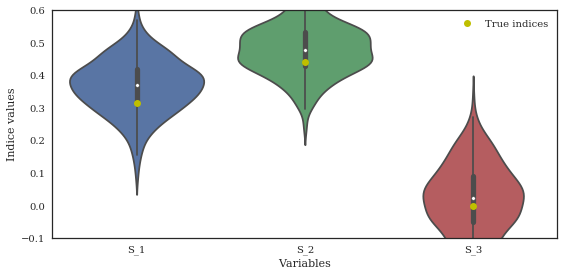

In [15]:
df_first_indices_mc = create_df_from_mc_indices(first_indices_mc)
plot_violin(df_first_indices_mc, with_hue=False, true_indices=ishigami.first_order_sobol_indices, ylim=ylim)

## Using a Kriging model to substitute the true model

### Building the model

In [5]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 100
basis = 'linear'
kernel = 'exponential'
sobol_kriging = SobolKrigingIndices(input_distribution)
meta_model = sobol_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel)

### The quality of the kriging model

#### With Leave One Out

In [6]:
score_q2_loo = meta_model.compute_score_q2_loo()
print('Leave One Out Q2 score:', score_q2_loo)

Leave One Out Q2 score: 0.660110745917


#### With cross validation

In [7]:
n_sample_cv = model_budget
score_q2_cv = meta_model.compute_score_q2_cv(n_sample_cv, sampling='lhs')
print('Cross Validation Q2 score with %d observations:' % (n_sample_cv), score_q2_cv)

Cross Validation Q2 score with 100 observations: 0.784138832208


### Estimating the indices

In [11]:
n_sample = 1000
n_realization = 100
evaluate_together = True
indiv_bootstraps = False
sobol_kriging.build_mc_sample(meta_model, n_sample, n_realization, evaluate_together=evaluate_together)
first_indices_gp = sobol_kriging.compute_indices(n_boot=n_boot, indiv_bootstraps=indiv_bootstraps, estimator='janon2')
df_first_indices_gp = create_df_from_gp_indices(first_indices_gp)

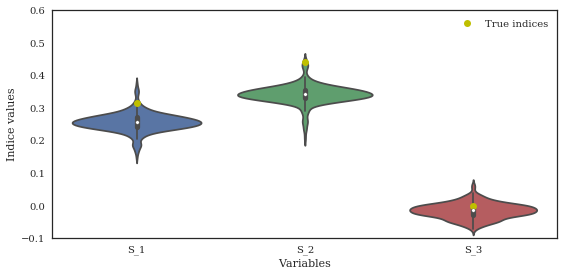

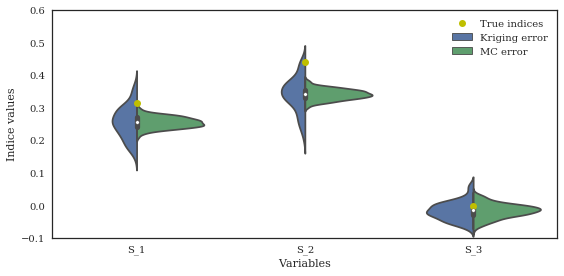

In [12]:
plot_violin(df_first_indices_gp, with_hue=False, true_indices=ishigami.first_order_sobol_indices, ylim=ylim)
plot_violin(df_first_indices_gp, with_hue=True, true_indices=ishigami.first_order_sobol_indices, ylim=ylim)

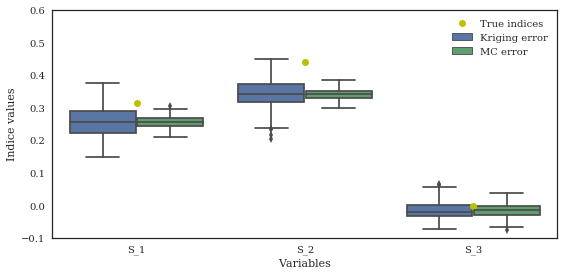

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x='Variables', y='Indice values', data=df_first_indices_gp, hue='Error', ax=ax)
ax.plot(ishigami.first_order_sobol_indices, 'yo', markersize=7, label='True indices')
ax.legend(loc=0)
ax.set_ylim(ylim)
fig.tight_layout()